In [2]:
# Verify that we are using the correct Python (/home/ata/miniconda3/envs/ml/bin/)
!which python
!which jupyter

/home/ata/miniconda3/envs/ml/bin/python
/home/ata/miniconda3/envs/ml/bin/jupyter


In [3]:
# Import the class from the Python file (module)
import pandas as pd
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from BinanceClient import BinanceClient
import numpy as np
from typing import Final
import joblib
from BatchFeatures import BatchFeatures
from datetime import datetime, timedelta
%matplotlib widget

#### Fetch pair data

In [4]:
# Initialize Binance client with your API credentials
# dotenv_path = Path('.env-secret')
# load_dotenv(dotenv_path=dotenv_path)
api_secret = os.getenv("BINANCE_SECRET_KEY")
api_key = os.getenv("BINANCE_API_KEY")

# Create Binance client & initialize it
pair = "BTCUSDT"
db_name = pair + "_1min"
binance_client = BinanceClient(db_name)
binance_client.set_interval("1m")
batch_feature = BatchFeatures()


In [23]:

# Create connection to fetch data
binance_client.make(api_key, api_secret)

# Get current server time
server_time = binance_client.get_server_time()

# Compute start and end time for the last x hours
server_time_dt = datetime.fromtimestamp(server_time['serverTime'] / 1000, tz=datetime.timezone.utc if hasattr(datetime, 'timezone') else None)
end_date = server_time_dt
# start_date = server_time_dt - timedelta(hours=10)
start_date = server_time_dt - timedelta(weeks=12)
start_date_str = int(start_date.timestamp() * 1000)  # Convert to milliseconds
end_date_str = int(end_date.timestamp() * 1000)      # Convert to milliseconds

# Fetch data
data = binance_client.fetch_data(pair, start_date_str, end_date_str)
binance_client.store_data_to_db(pair, data)

# Check if data is fetched
if not data.empty:
    # Convert the fetched data into a pandas DataFrame
    df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

    # Set the timestamp as the index
    df.set_index('timestamp', inplace=True)

    # Convert the columns to numeric (some values may be strings by default)
    df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].apply(pd.to_numeric)
else:
    print("No data found!!!.")

Fetching data from Binance API...


In [5]:
#Fetch data from db
df = binance_client.fetch_data_from_db(pair)

#### Define target 

In [19]:
# Predict the percentage price change over the next 'n' candles
nn = 10
df['target'] = (df['close'].shift(nn) - df['close']) / df['close'] * 100

#### Feature engineering

In [11]:
# Feature Engineering (mind the order since some features are depended on others)
bf = BatchFeatures()
bf.calculate_sma(df)
bf.calculate_ema(df)
bf.calculate_rsi(df)
bf.calculate_macd(df)
bf.calculate_bollinger_bands(df)
bf.calculate_atr(df)
bf.calculate_volume_features(df)
bf.calculate_roc(df)
bf.calculate_lagged_features(df)
bf.calculate_candle_features(df)

#### Test/Train Split

In [12]:
# drop NaNs
df.dropna(inplace=True)

# df is sorted by time and indexed by a datetime index
n = len(df)
train_end = int(n * 0.8) # 80% data used for training
train_df = df.iloc[:train_end]
test_df = df.iloc[train_end:]

# Separate features and target
X_train = train_df.drop(['target', 'close'], axis=1)
y_train = train_df['target']

X_test = test_df.drop(['target', 'close'], axis=1)
y_test = test_df['target']


In [ ]:
import matplotlib.pyplot as plt
plt.clf()
plt.figure(figsize=(12, 6))
plt.plot(train_df['close'], label="Actual", alpha=0.8)

#### Grid Search for Hyperparameter Tuning 

In [14]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# # Define the model with GPU support
# xgb_reg = XGBRegressor(tree_method='hist', device='cuda')

# # Define your model and pipeline
# pipeline = Pipeline([
#     ('scaler', StandardScaler()),  # Scaling step
#     ('regressor', xgb_reg)  # Model
# ])
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling step
    ('regressor', RandomForestRegressor())  # Model
])

# Define hyperparameter grid for the regressor
param_grid = {
    'regressor__n_estimators': [10, 50, 100],
    'regressor__max_depth': [3, 5, 10],
    'regressor__max_features': [5, 10, 15],
    'regressor__bootstrap': [True, False]
}
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.2],
# }


# Use TimeSeriesSplit for cross-validation
time_series_split = TimeSeriesSplit(n_splits=5)

# Perform grid search with pipeline
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='neg_mean_squared_error',
    cv=time_series_split,
    return_train_score=True,
    verbose=3
)

# Fit the pipeline
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END regressor__bootstrap=True, regressor__max_depth=3, regressor__max_features=5, regressor__n_estimators=10;, score=(train=-0.009, test=-0.037) total time=   0.5s
[CV 2/5] END regressor__bootstrap=True, regressor__max_depth=3, regressor__max_features=5, regressor__n_estimators=10;, score=(train=-0.023, test=-0.014) total time=   0.8s
[CV 3/5] END regressor__bootstrap=True, regressor__max_depth=3, regressor__max_features=5, regressor__n_estimators=10;, score=(train=-0.016, test=-0.006) total time=   1.2s
[CV 4/5] END regressor__bootstrap=True, regressor__max_depth=3, regressor__max_features=5, regressor__n_estimators=10;, score=(train=-0.012, test=-0.005) total time=   1.5s
[CV 5/5] END regressor__bootstrap=True, regressor__max_depth=3, regressor__max_features=5, regressor__n_estimators=10;, score=(train=-0.013, test=-0.013) total time=   1.9s
[CV 1/5] END regressor__bootstrap=True, regressor__max_depth=3, regressor

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor', RandomForestRegressor())]),
             param_grid={'regressor__bootstrap': [True, False],
                         'regressor__max_depth': [3, 5, 10],
                         'regressor__max_features': [5, 10, 15],
                         'regressor__n_estimators': [10, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=3)

#### Save GridSearch Results

In [15]:

# Save the GridSearchCV object
joblib.dump(grid_search, 'grid_search_results_1min_nn10.pkl')

['grid_search_results_1min_nn10.pkl']

#### Load saves GridSearch results

In [17]:

# Load GridSearch results
grid_search = joblib.load('grid_search_results_1sec_nn12.pkl')
# grid_search = joblib.load('grid_search_results.pkl')


#### Analyse grid search results

In [16]:
# Access best parameters or results
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Best model
best_model = grid_search.best_estimator_


Best Parameters: {'regressor__bootstrap': False, 'regressor__max_depth': 10, 'regressor__max_features': 15, 'regressor__n_estimators': 50}
Best Score: -0.001007909903643664


#### Best Model Training

In [13]:
from sklearn.ensemble import RandomForestRegressor

# Extract best parameters from GridSearchCV
best_params = grid_search.best_params_

# Remove 'regressor__' prefix to pass parameters directly to the model
model_params = {key.replace('regressor__', ''): value for key, value in best_params.items()}

# Train the model using the best parameters
best_model = RandomForestRegressor(**model_params)

# NOTE: Feature scaling is not requiredfor Random Forest regressor
best_model.fit(X_train, y_train)

# Get feature importances
feature_importances = best_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 features
print(feature_importance_df.head(10))

         Feature  Importance
16        roc_10    0.434646
7         rsi_14    0.234784
10     macd_hist    0.158853
8           macd    0.096573
9    macd_signal    0.018873
13        atr_14    0.017187
3         volume    0.015788
14  volume_ma_20    0.008661
20   candle_body    0.003786
15  volume_ratio    0.001593


In [14]:
# Save the model
joblib.dump(best_model, 'best_model_12candles.joblib')

['best_model_12candles.joblib']

In [10]:
# load the best model
best_model = joblib.load('best_model_12candles.joblib')

#### Best Model Prediction

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict on test data
y_pred = best_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R² Score:", r2)


Mean Squared Error (MSE): 0.024960832868167176
Mean Absolute Error (MAE): 0.10904342529635946
R² Score: 0.8976863012167029


In [ ]:
import matplotlib.pyplot as plt
plt.clf()
plt.figure(figsize=(12, 6))
plt.plot(y_train.values, label="Actual", alpha=0.8)
plt.plot(y_pred, label="Predicted", alpha=0.8)
plt.plot(y_test.values-y_pred, label="Actual", alpha=0.8)
plt.legend()
plt.title("Actual vs. Predicted Stock Price Changes (Next Hour)")
plt.xlabel("Time Steps")
plt.ylabel("Percentage Change")
plt.show()


#### Generate Predictions

In [54]:
# Use the model's predictions
predictions = pd.DataFrame(best_model.predict(X_test))  # Predicted percentage changes
y_pred_train  = pd.DataFrame(best_model.predict(X_train))  # Predicted percentage changes

### Trading Signal Generation & Back Testing

In [103]:
INITIAL_BALANCE = 1000  # Starting with $10,000

##### Trade Simulator

In [13]:
def simulate_trades(signals, prices, initial_balance=1000):
    """
    Simulates trades based on signals and actual price changes.

    Args:
        actual_changes (list or pd.Series): Actual percentage changes (not predicted).
        signals (list): List of trading signals ("Buy", "Sell", "Hold").
        prices (list or pd.Series): Actual price values for the asset.
        initial_balance (float): Starting balance of the trading account.

    Returns:
        float: Final balance or cumulative profit.
    """
    balance = INITIAL_BALANCE
    position = 0  # Tracks the number of stocks held
    entry_price = None  # Store the price when a "Buy" was executed
    
    for i, signal in enumerate(signals):
        if signal == "Buy" and balance > 0:
            # Execute a buy
            entry_price = prices.iloc[i]  # Use .iloc for positional indexing
            position = balance / entry_price  # Buy with all available balance
            balance = 0  # All balance used to buy
        elif signal == "Sell" and position > 0:
            # Execute a sell
            exit_price = prices.iloc[i]  # Use .iloc for positional indexing
            balance = position * exit_price  # Convert position to cash
            position = 0  # Clear position
            entry_price = None  # Reset entry price after selling

    # If there's a remaining position at the end, calculate its value
    if position > 0 and entry_price is not None:
        balance += position * prices.iloc[-1]  # Use .iloc for positional indexing

    return balance - INITIAL_BALANCE  # Return cumulative profit


#### Trade Signal Generation

##### Advance Trade Signal Generation

**Generate a Search Space**

In [87]:
import numpy as np
buy_thresholds = np.arange(-2.0, -0.031, 0.01)
sell_thresholds = np.arange(0.01, 2.0, 0.01)

# Add signals to a DataFrame for analysis
results_df = X_test.copy()
results_df['Predicted Change'] = predictions.shift(-nn).values
# Compute predicted prices based on the previous close and Predicted Change
results_df['Predicted Price'] = results_df['close_lag_1'] * (1 + results_df['Predicted Change'] / 100)

In [ ]:
plt.clf()
plt.figure(figsize=(12, 6))
plt.plot(results_df['Predicted Price'], label="Predicted", alpha=0.8)
plt.plot(test_df['close'], label="Actual", alpha=0.8)
plt.legend()
plt.title("Actual vs. Predicted Stock Price Changes (Next Hour)")
plt.xlabel("Time Steps")
plt.ylabel("Percentage Change")
plt.show()


##### Evaluate Thresholds

In [130]:
best_buy_threshold = None
best_sell_threshold = None
best_performance = -np.inf

ii = 0
jj = 0
performance = np.zeros((len(buy_thresholds), len(sell_thresholds)))

for buy_th in buy_thresholds:
    for sell_th in sell_thresholds:
        # Generate signals
        trading_signals = [
            "Buy" if pred < buy_th else "Sell" if pred > sell_th else "Hold"
            for pred in results_df['Predicted Change'].values
        ]
        
        # Simulate trades and calculate performance
        performance[ii, jj] = simulate_trades(
            signals=trading_signals,
            prices=results_df['Predicted Price'],  # Use the computed predicted prices
            initial_balance=INITIAL_BALANCE
        )
        # Update best thresholds if current performance is better
        if performance[ii, jj] > best_performance:
            best_performance = performance[ii, jj]
            best_buy_threshold = buy_th
            best_sell_threshold = sell_th
        jj += 1
    ii += 1
    jj = 0
print(f"Best Buy Threshold: {best_buy_threshold}, Best Sell Threshold: {best_sell_threshold}")
print(f"Best Performance: {best_performance}")


Best Buy Threshold: -0.37999999999999856, Best Sell Threshold: 0.3
Best Performance: 123103.93742948317


#### Beck Testing 

In [112]:
# Define buy & sell thrsholds
buy_threshold = -0.37999999999999856
sell_threshold = 0.29000000000000004

balance = INITIAL_BALANCE
position = 0  # No stock initially
trading_log = []  # To store completed trades

# Generate signals with reversed logic
trading_signals = [
    "Buy" if pred < buy_threshold else "Sell" if pred > sell_threshold else "Hold"
    for pred in results_df['Predicted Change']
]

results_df['Signal'] = trading_signals

# Add 'open' and 'close' prices from the original DataFrame to results DataFrame
results_df['open'] = df.loc[results_df.index, 'open']
results_df['close'] = df.loc[results_df.index, 'close']

# Variables to track ongoing trades
buy_price = None
buy_date = None
buy_volume = None

# Iterate over results_df for backtesting
for index, row in results_df.iterrows():
    signal = row['Signal']
    price = row['Predicted Price']  # Use 'open' price for Buy
    # volume = balance / price if signal == "Buy" and balance > 0 else position  # Calculate volume

    if signal == "Buy" and balance > 0:
        # Record Buy details
        buy_price = price
        buy_date = index
        buy_volume = balance / price
        position = buy_volume  # Update position
        balance = 0  # All money is invested

    elif signal == "Sell" and position > 0:
        # Calculate profit/loss for the completed trade
        sell_price = price  # Use 'close' price for Sell
        profit_loss = (sell_price - buy_price) * buy_volume
        balance = sell_price * buy_volume  # Update balance after selling
        position = 0  # No stock left

        # Record the completed trade in the log
        trading_log.append({
            "Buy Date": buy_date,
            "Buy Price": buy_price,
            "Buy Volume": buy_volume,
            "Sell Date": index,
            "Sell Price": sell_price,
            "Profit/Loss": profit_loss
        })

        # Reset Buy details
        buy_price = None
        buy_date = None
        buy_volume = None

# Final portfolio value
if position > 0:
    final_price = results_df.iloc[-1]['Predicted Price']
    final_profit_loss = (final_price - buy_price) * buy_volume
    balance = final_price * buy_volume  # Update balance with remaining shares
    trading_log.append({
        "Buy Date": buy_date,
        "Buy Price": buy_price,
        "Buy Volume": buy_volume,
        "Sell Date": results_df.index[-1],
        "Sell Price": final_price,
        "Profit/Loss": final_profit_loss
    })

# Convert trading log to a DataFrame for better analysis
trading_log_df = pd.DataFrame(trading_log)

# Print the final results
print(f"Final Balance: ${balance:.2f}")
print(f"Net Profit: ${balance - INITIAL_BALANCE:.2f}")



Final Balance: $123544.48
Net Profit: $122544.48


In [ ]:
import matplotlib.pyplot as plt
plt.clf()
plt.hist(predictions, bins=50, alpha=0.7)
plt.title("Distribution of Predictions")
plt.xlabel("Predicted Change")
plt.ylabel("Frequency")
plt.show()


#### Compute Baseline

In [106]:
# Get starting and ending prices
initial_price = results_df.iloc[0]['close']  # Opening price at the first date
final_price = results_df.iloc[-1]['close']  # Closing price at the last date

# Calculate number of shares purchased with initial balance
shares = INITIAL_BALANCE / initial_price

# Calculate final balance
final_balance_baseline = shares * final_price

# Calculate profit/loss for the baseline strategy
profit_loss_baseline = final_balance_baseline - INITIAL_BALANCE

# Print results
print(f"Baseline Final Balance: ${final_balance_baseline:.2f}")
print(f"Baseline Strategy Profit/Loss: ${profit_loss_baseline:.2f}")


Baseline Final Balance: $1509.35
Baseline Strategy Profit/Loss: $509.35


#### Baseline Comparison

In [107]:
# Assuming `profit_loss_estimator` is calculated from your trading log
profit_loss_estimator = trading_log_df['Profit/Loss'].sum()

# Calculate difference and percentage improvement
difference = profit_loss_estimator - profit_loss_baseline
improvement_percentage = (difference / abs(profit_loss_baseline)) * 100 if profit_loss_baseline != 0 else None

# Print comparison
print(f"Estimator Profit/Loss: ${profit_loss_estimator:.2f}")
print(f"Difference vs. Baseline: ${difference:.2f}")
if improvement_percentage is not None:
    print(f"Performance Improvement: {improvement_percentage:.2f}%")
else:
    print("Baseline profit/loss is zero, percentage improvement cannot be calculated.")


Estimator Profit/Loss: $122544.48
Difference vs. Baseline: $122035.13
Performance Improvement: 23959.04%


In [95]:
# Calculate momentum (percentage change in price)
momentum_threshold = 0.01  # 1% change as momentum threshold
momentum_signals = results_df['close'].pct_change()  # Calculate percentage change
momentum_trades = momentum_signals[momentum_signals.abs() > momentum_threshold]

# Initialize profit/loss calculation for momentum strategy
momentum_profit_loss = 0
balance = INITIAL_BALANCE
position = 0

# Iterate through momentum trades
for idx, change in momentum_trades.items():  # Use .items() for Series iteration
    price = results_df.loc[idx, 'close']
    if change > 0 and balance > 0:  # Buy signal
        position = balance / price
        balance = 0
    elif change < 0 and position > 0:  # Sell signal
        balance = position * price
        position = 0

# Final balance if still holding shares
if position > 0:
    balance += position * results_df.iloc[-1]['close']

momentum_profit_loss = balance - INITIAL_BALANCE

print(f"Momentum Strategy Profit/Loss: ${momentum_profit_loss:.2f}")


Momentum Strategy Profit/Loss: $3364.80


In [97]:
rolling_window = 20
results_df['SMA'] = results_df['close'].rolling(rolling_window).mean()
results_df['Deviation'] = results_df['close'] - results_df['SMA']

# Drop NaN rows to avoid issues with rolling mean
mean_reversion_trades = results_df.dropna()

# Generate signals explicitly with .loc
mean_reversion_trades.loc[:, 'Signal'] = mean_reversion_trades['Deviation'].apply(
    lambda x: 'Buy' if x < 0 else 'Sell'
)

# Simulate mean-reversion trading
balance = INITIAL_BALANCE
position = 0
mean_reversion_profit_loss = 0

for idx, row in mean_reversion_trades.iterrows():
    price = row['close']
    signal = row['Signal']
    if signal == 'Buy' and balance > 0:  # Buy
        position = balance / price
        balance = 0
    elif signal == 'Sell' and position > 0:  # Sell
        balance = position * price
        position = 0

# Final balance if still holding shares
if position > 0:
    balance += position * results_df.iloc[-1]['close']

mean_reversion_profit_loss = balance - INITIAL_BALANCE

print(f"Mean-Reversion Strategy Profit/Loss: ${mean_reversion_profit_loss:.2f}")


Mean-Reversion Strategy Profit/Loss: $2091.06


In [98]:
print(f"ML Estimator Profit/Loss: ${profit_loss_estimator:.2f}")
print(f"Baseline Profit/Loss: ${profit_loss_baseline:.2f}")
print(f"Momentum Strategy Profit/Loss: ${momentum_profit_loss:.2f}")
print(f"Mean-Reversion Strategy Profit/Loss: ${mean_reversion_profit_loss:.2f}")

ML Estimator Profit/Loss: $1031817.87
Baseline Profit/Loss: $5093.49
Momentum Strategy Profit/Loss: $3364.80
Mean-Reversion Strategy Profit/Loss: $2091.06


#### Visualizations

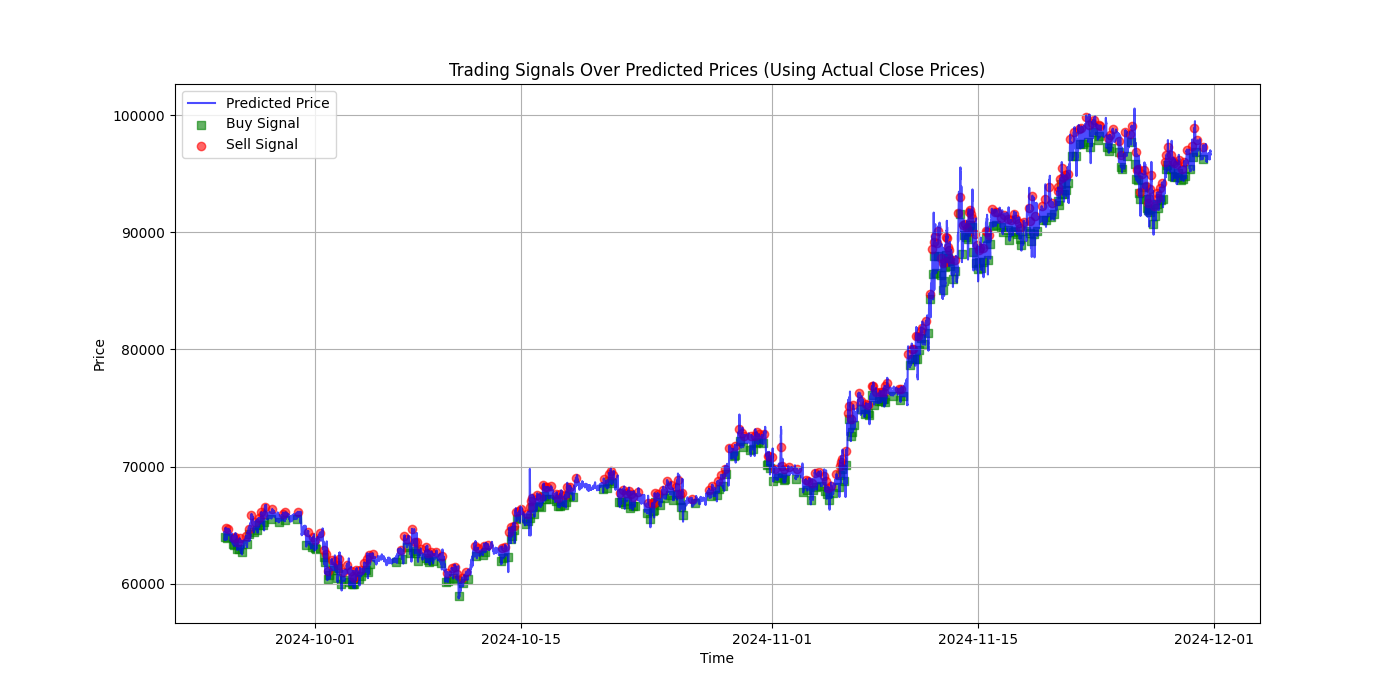

In [104]:
import matplotlib.pyplot as plt

# Add predicted prices to results_df
results_df['Predicted Price'] = results_df['close'] * (1 + results_df['Predicted Change'] / 100)

# Plot the predicted prices
plt.clf()
plt.figure(figsize=(14, 7))
plt.plot(results_df.index, results_df['Predicted Price'], label='Predicted Price', color='blue', alpha=0.7)

# Use trading_log_df for Buy and Sell points
buy_signals = trading_log_df.dropna(subset=['Buy Date'])
sell_signals = trading_log_df.dropna(subset=['Sell Date'])

# Map Buy/Sell signals to values from results_df['close']
buy_close_prices = [results_df.loc[row['Buy Date'], 'Predicted Price'] for _, row in buy_signals.iterrows()]
sell_close_prices = [results_df.loc[row['Sell Date'], 'Predicted Price'] for _, row in sell_signals.iterrows()]

# Plot Buy signals as green squares at actual 'close' prices
plt.scatter(
    buy_signals['Buy Date'],
    buy_close_prices,
    label='Buy Signal',
    color='green',
    marker='s',
    alpha=0.6
)

# Plot Sell signals as red circles at actual 'close' prices
plt.scatter(
    sell_signals['Sell Date'],
    sell_close_prices,
    label='Sell Signal',
    color='red',
    marker='o',
    alpha=0.6
)

# Add labels, title, legend, and grid
plt.title("Trading Signals Over Predicted Prices (Using Actual Close Prices)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Add predicted prices to results_df (if not already added)
results_df['Predicted Price'] = results_df['close'] * (1 + results_df['Predicted Change'] / 100)

# Plot the predicted prices
plt.figure(figsize=(14, 7))
plt.plot(results_df.index, results_df['close'], label='Actual Close', color='blue', alpha=0.7)

# Use trading_log_df for Buy and Sell points
buy_signals = trading_log_df.dropna(subset=['Buy Date'])
sell_signals = trading_log_df.dropna(subset=['Sell Date'])

# Add vertical lines for Buy signals
for _, row in buy_signals.iterrows():
    plt.axvline(
        x=row['Buy Date'], 
        color='green', 
        linestyle='--', 
        linewidth=2,  # Increased line thickness
        label='Buy Signal' if 'Buy Signal' not in plt.gca().get_legend_handles_labels()[1] else "", 
        alpha=0.25
    )

# Add vertical lines for Sell signals
for _, row in sell_signals.iterrows():
    plt.axvline(
        x=row['Sell Date'], 
        color='red', 
        linestyle='-', 
        linewidth=2,  # Increased line thickness
        label='Sell Signal' if 'Sell Signal' not in plt.gca().get_legend_handles_labels()[1] else "", 
        alpha=0.25
    )

# Add labels, title, legend, and grid
plt.title("Trading Signals Over Predicted Prices (Using Vertical Lines)")
plt.xlabel("Time")
plt.ylabel("Predicted Price")
plt.legend()
plt.grid(True)
plt.show()


In [37]:
# Predict the percentage price change over the next 'n' candles
nn = 10
df['target'] = (df['close'].shift(nn) - df['close']) / df['close'] * 100

In [ ]:
corr_matrix = df.corr()
plt.figure(figsize=(16, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f")
plt.show()

In [38]:
# Identify highly correlated features
threshold = 0.95  # Adjust threshold as needed
corr_matrix = df.corr()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features to drop
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

# Drop the features
df_reduced = df.drop(columns=to_drop)
print(f"Dropped features: {to_drop}")


Dropped features: ['high', 'low', 'close', 'sma_10', 'sma_50', 'ema_10', 'macd_signal', 'bollinger_upper', 'bollinger_lower', 'close_lag_1', 'close_lag_3', 'macd_lag_1']


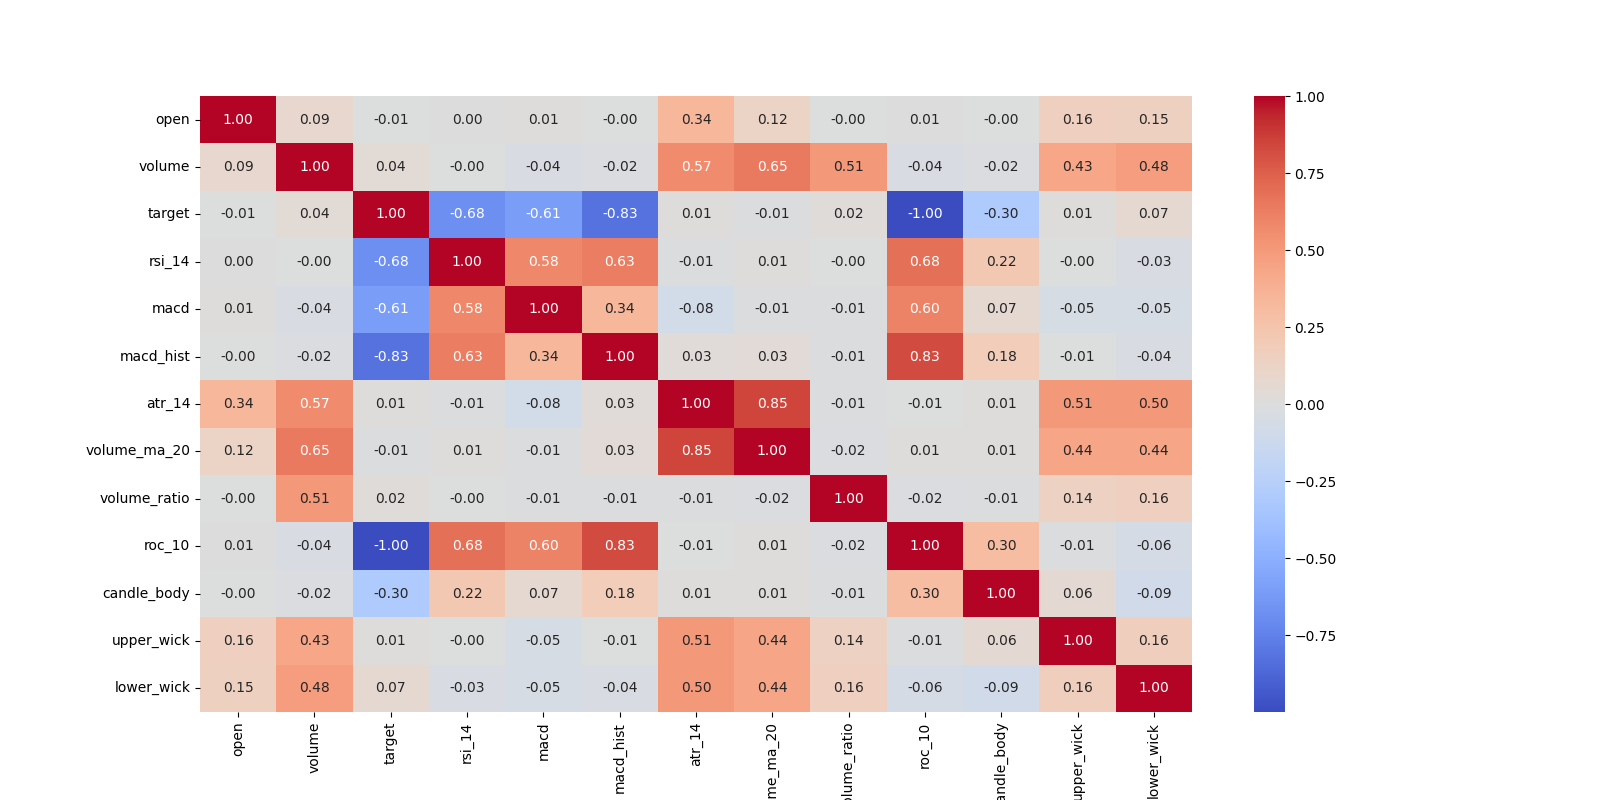

In [39]:
corr_matrix = df_reduced.corr()
plt.figure(figsize=(16, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f")
plt.show()

In [41]:
# drop NaNs
df_reduced.dropna(inplace=True)

# df is sorted by time and indexed by a datetime index
n = len(df_reduced)
train_end_reduced = int(n * 0.8) # 80% data used for training
train_df_reduced = df_reduced.iloc[:train_end_reduced]
test_df_reduced = df_reduced.iloc[train_end_reduced:]

# Separate features and target
X_train_reduced = train_df_reduced.drop(['target'], axis=1)
y_train_reduced = train_df_reduced['target']

X_test_reduced = test_df_reduced.drop(['target'], axis=1)
y_test_reduced = test_df_reduced['target']


In [ ]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling step
    ('regressor', RandomForestRegressor())  # Model
])

# Define hyperparameter grid for the regressor
param_grid = {
    'regressor__n_estimators': [10, 50, 100],
    'regressor__max_depth': [3, 5, 10],
    'regressor__max_features': [5, 10, 15],
    'regressor__bootstrap': [True, False]
}

# Use TimeSeriesSplit for cross-validation
time_series_split = TimeSeriesSplit(n_splits=5)

# Perform grid search with pipeline
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='neg_mean_squared_error',
    cv=time_series_split,
    return_train_score=True,
    verbose=3
)

# Fit the pipeline
grid_search.fit(X_train_reduced, y_train_reduced)

In [ ]:
import cupy as cp
X_train_gpu = cp.array(X_train)
y_train_gpu = cp.array(y_train)


In [ ]:
# Sharpe Ratio Calculations


# Ensure 'Buy Date' and 'Sell Date' are datetime
trading_log_df['Buy Date'] = pd.to_datetime(trading_log_df['Buy Date'])
trading_log_df['Sell Date'] = pd.to_datetime(trading_log_df['Sell Date'])

# Add a 'Sell Date (Day)' column for aggregation
trading_log_df['Sell Date (Day)'] = trading_log_df['Sell Date'].dt.date

# Aggregate profit/loss by day
daily_returns_df = trading_log_df.groupby('Sell Date (Day)')['Profit/Loss'].sum().reset_index()
daily_returns_df.rename(columns={'Profit/Loss': 'Daily Profit/Loss'}, inplace=True)

# Calculate daily returns as a percentage of the initial balance
daily_returns_df['Daily Return'] = daily_returns_df['Daily Profit/Loss'] / initial_balance

# Calculate average and standard deviation of daily returns
average_daily_return = daily_returns_df['Daily Return'].mean()
std_dev_daily_return = daily_returns_df['Daily Return'].std()

# Compute Sharpe Ratio
risk_free_rate = 0  # Assuming no risk-free rate for simplicity
sharpe_ratio_estimator = (average_daily_return - risk_free_rate) / std_dev_daily_return

print(f"Sharpe Ratio (Estimator): {sharpe_ratio_estimator:.2f}")




# Total duration of the baseline strategy (in days)
total_days = (results_df.index[-1] - results_df.index[0]).days

# Baseline return: Profit/Loss normalized by initial balance
baseline_return = (final_price - initial_price) / initial_price

# Average daily return for the baseline
baseline_average_daily_return = baseline_return / total_days

# Standard deviation of daily returns for baseline (set a small epsilon if zero)
baseline_std_dev_daily_return = max(np.std([baseline_return]), 1e-8)  # Avoid division by zero

# Compute Sharpe Ratio for baseline
sharpe_ratio_baseline = baseline_average_daily_return / baseline_std_dev_daily_return

# Print results
print(f"Baseline Return: {baseline_return * 100:.2f}%")
print(f"Baseline Average Daily Return: {baseline_average_daily_return * 100:.4f}%")
print(f"Baseline Sharpe Ratio: {sharpe_ratio_baseline}")



In [ ]:
def generate_signals(predictions, actual_prices, buy_threshold, sell_threshold):
    signals = [
        1 if pred - actual < buy_threshold else -1 if pred - actual > sell_threshold else 0
        for pred, actual in zip(predictions, actual_prices)
    ]
    return signals
from sklearn.base import BaseEstimator

class ThresholdOptimizer(BaseEstimator):
    def __init__(self, buy_threshold=-0.5, sell_threshold=0.5):
        self.buy_threshold = buy_threshold
        self.sell_threshold = sell_threshold

    def fit(self, X, y=None):
        # No training required for this optimizer
        return self

    def predict(self, X):
        # Generate signals based on thresholds
        return [
            1 if pred < self.buy_threshold else -1 if pred > self.sell_threshold else 0
            for pred in X
        ]


from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
# Define parameter grid
param_grid = {
    'buy_threshold': np.linspace(-2.0, -1, 10),
    'sell_threshold': np.linspace(0.1, 2.0, 10),
}

class CustomGridSearchCV(GridSearchCV):
    def __init__(self, estimator, param_grid, cv=5, verbose=0):
        super().__init__(estimator=estimator, param_grid=param_grid, cv=cv, verbose=verbose)
        print(f'Custom Grid INIT!!!!')
    
    def custom_scorer(self, X, y):
        """
        Custom scoring function that directly uses self.estimator.
        """
        try:
            print(f'Scoring... {X}')
            signals = self.best_estimator_.predict(X)
            
            if len(signals) != len(y):
                raise ValueError("Signals and target length mismatch.")
            
            profit_loss = 0
            for i in range(len(y) - 1):
                if signals[i] == 1:  # Buy signal
                    profit_loss += y[i + 1] - y[i]
                elif signals[i] == -1:  # Sell signal
                    profit_loss += y[i] - y[i + 1]
            
            return profit_loss

        except Exception as e:
            print(f"Error in scoring: {e}")
            return -float('inf')  # Penalize invalid scoring

    def score(self, X, y, greater_is_better=True):
        # Use the custom scoring function
        print(f'Custom Grid SCORING!!!!')
        return self.custom_scorer(X, y)

# Use the CustomGridSearchCV class
custom_grid_search = CustomGridSearchCV(
    estimator=ThresholdOptimizer(),
    param_grid=param_grid,
    cv=5,
    verbose=3
)

# Perform the search
# Add predictions to the training data
X_train['Predicted Change'] = y_pred_train  # Replace 'y_pred_train' with actual predictions
# Perform the search
grid_search.fit(X_train['Predicted Change'].values.reshape(-1, 1), y_train)


# Get the best thresholds
best_params = grid_search.best_params_
print(f"Best Buy Threshold: {best_params['buy_threshold']}")
print(f"Best Sell Threshold: {best_params['sell_threshold']}")




In [ ]:
def simulate_trades_with_penalty(predicted_changes, signals, initial_balance=1000):
    balance = initial_balance
    position = 0
    trades = 0  # Count the number of trades
    penalty = 0  # Initialize penalty for excessive trading

    for change, signal in zip(predicted_changes, signals):
        if signal == "Buy":
            position += balance / 100
            balance = 0
            trades += 1
        elif signal == "Sell" and position > 0:
            balance += position * (1 + change / 100)
            position = 0
            trades += 1
        # "Hold" means do nothing
    
    balance += position * (1 + predicted_changes.iloc[-1] / 100)
    
    # Apply penalty for excessive trades
    penalty = -0.01 * trades  # Example penalty, adjust as needed
    return balance - initial_balance + penalty


In [8]:
import sqlite3
db_name="binance_data.db"
conn = sqlite3.connect(db_name)
cursor = conn.cursor()
cursor.execute("PRAGMA journal_mode=DELETE;")
conn.commit()
conn.close()